<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/Presentation_Transfer_Learning_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning and applying PCA to K-Means

- Requires Google Colab Pro Plus. 'High-RAM' of 51GB setting to be set


---



In [25]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
!ls

Cloning into 'MADSmilestone2'...
remote: Enumerating objects: 802, done.
remote: Counting objects: 100% (802/802), done.
remote: Compressing objects: 100% (674/674), done.
Receiving objects: 100% (802/802), 7.71 MiB | 8.24 MiB/s, done.
remote: Total 802 (delta 435), reused 273 (delta 118), pack-reused 0
Resolving deltas: 100% (435/435), done.
/content/MADSmilestone2/MADSmilestone2
Analysis.ipynb		multimodel2.ipynb
CNN2_scores.ipynb	presentation_CNN2_scores.ipynb
Data			presentation_Supervised_CNN.ipynb
dataloader_tests.ipynb	proj_models.py
ImagePlayground		README.md
Labeling		scores_cnn_resnet.ipynb
Loading			Supervised_CNN.ipynb
Model_Datasets.ipynb	Transfer_Learning_Kmeans.ipynb
multimodel1.ipynb	utils.py


In [26]:
!pip install boto3 torchmetrics


# Pytroch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchmetrics
from torch.autograd import Variable

# Other Libraries
import botocore
import tempfile
from tqdm import tqdm
import boto3
import io
import os
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Sklearn libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


# Custom Libraries
import Loading.load_data as ld
from utils import open_dict
from proj_models import ResizedClocks
from utils import collate_fn
from utils import set_model
from utils import accuracy
from proj_models import ConvNet
from utils import train_val_model


In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
# also import keys for aws connection
from gdrive.MyDrive.Colab_Notebooks.clocks_aws_config import clockss3
pubkey = clockss3['accessCode']
seckey = clockss3['secretCode']
client = boto3.client('s3', aws_access_key_id=pubkey, aws_secret_access_key=seckey)
#response = client.list_buckets()

In [29]:
path = '/content/MADSmilestone2/Data/Dictionaries/dementia_label_dicts/train_dict_nhat.txt'
cust_file = open(path, "r")
#print(cust_file.readline())
contents = cust_file.read() 
dictionarytr = ast.literal_eval(contents)
cust_file.close()

path1 = '/content/MADSmilestone2/Data/Dictionaries/dementia_label_dicts/val_dict_nhat.txt'
cust_file = open(path1, "r")
#print(cust_file.readline())
contents = cust_file.read()
dictionaryv = ast.literal_eval(contents)
cust_file.close()

path2 = '/content/MADSmilestone2/Data/Dictionaries/dementia_label_dicts/test_dict_nhat.txt'
cust_file = open(path2, "r")
#print(cust_file.readline())
contents = cust_file.read()
dictionaryts = ast.literal_eval(contents)
cust_file.close()

In [30]:
# Define some of the loader variables
train_batch_size = 1
val_batch = 4
test_batch = 1
rnd = 7
normalize_ = True

# Set to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# set model parameters to choose model for extracting features
m = 'res50'# 'conv'
model_ext = '4_fix'

In [31]:
train_set = ResizedClocks(rnd, dictionarytr[rnd], pubkey, seckey, normalize_=True)
val_set = ResizedClocks(rnd, dictionaryv[rnd], pubkey, seckey, normalize_=True)
test_set = ResizedClocks(rnd, dictionaryts[rnd], pubkey, seckey, normalize_=True)

In [32]:
# Define Dataloaders for the network
train_loader = torch.utils.data.DataLoader(train_set, batch_size = train_batch_size, shuffle = True, num_workers = 6, collate_fn=collate_fn) 
validate_loader = torch.utils.data.DataLoader(val_set, batch_size = val_batch, shuffle = True, num_workers = 6, collate_fn=collate_fn) #64, 8,1

In [33]:
# For round 10, there are some corrupt data that when batched at size 1 is not taken
# care of by the collate function, but Nonechucks library skips the missing data and 
# moves on, replacing that missing data index with the next piece of data
# could probably just use this in place of collate for all the loading
if rnd == 10:
  !pip install nonechucks
  import nonechucks as nc
  test_set_safe = nc.SafeDataset(test_set)
  test_loader = torch.utils.data.DataLoader(test_set_safe, batch_size = test_batch, shuffle = False)
else:
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = test_batch, shuffle = False, collate_fn=collate_fn)

In [34]:
# Get model
if m == 'conv':
  model_ext = '4_fix'
  mPATH = '/content/gdrive/MyDrive/Colab Notebooks/Models/cnn_512_662.model{}'.format(model_ext)
  model = ConvNet()
  #model.load_state_dict(torch.load(mPATH, map_location=torch.device('cpu')))
  model.load_state_dict(torch.load(mPATH))
  model.to(device)
  print("conv")

if m == 'res50':
  model = models.resnet50(pretrained = True)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 3)
  model = model.to(device)
  print("res 50 pretrained")

res 50 pretrained


In [11]:
#original size: 2560, 3312
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    
    # without considering batch size: Input shape : (None,368, 284, 1) , parameters: (3*3*1*16+16) = 160
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, # one input channel gray scale, 16 filters out
                            kernel_size = 3, stride = 1, padding = 1) #Out:(None,386, 284, 16). ### TRY kernel 7x7 padding 3
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640                        
    self.pool1 = nn.MaxPool2d(2, 2) #Out: (None, 184, 142, 32) 
    self.bn1 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640    
    self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248                    
    self.pool2 = nn.MaxPool2d(2, 2) #Output shape = (None, 92, 71, 64) 
    self.bn2 = nn.BatchNorm2d(64)  

    #self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, 
                          #kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248 
    self.conv6 = nn.Conv2d(in_channels = 64, out_channels = 128, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248
    self.pool3 = nn.MaxPool2d(2, 2) #Output shape = (None, 46, 35, 128) 
    self.bn3 = nn.BatchNorm2d(128)
    self.do2 = nn.Dropout(0.3)
                                   
                             
    # Fully connected layer
    self.fc1 = nn.Linear(128*64*82,60) #most recent original size of: 512, 662 -->64 x 82
    self.do3 = nn.Dropout(0.4) #40 % probability  
    #self.fc3 = nn.Linear(60, 30)
    self.fc2 = nn.Linear(60, 3) # left with 3 for the three classes                     



  def forward(self, x):
    x = self.bn1(self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))))
    x = self.bn2(self.pool2(F.relu(self.conv4(F.relu(self.conv3(x))))))
    #x = self.bn3(self.pool3(F.relu(self.conv6(F.relu(self.conv5(x))))))
    x = self.bn3(self.pool3(F.relu(self.conv6((x)))))
    x = self.do2(x)
    x = x.view(x.size(0),128*64*82)
    x = F.relu(self.fc1(x))
    x = self.do3(x)
    x = self.fc2(x)
    return x              

# Transfer Learning with PCA and K-Means

### Prepare the Data

In [35]:
# Remove prediction layer (last fc layer)
if m == 'res50':
  model_1 = nn.Sequential(*list(model.children())[:-1])
else:
  model_1 = nn.Sequential(*list(model.children())[:-3]) # removes last FCs of CNN

In [36]:
# Use model for evaluation
model_1.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
# Set
X = []
for x, lb in tqdm(test_loader):
  # Get image features from model
  x = x.to(device)
  preds = model_1(x)
  X.append(preds.cpu())


In [ ]:
print("Shape of Tensor Array: ", X[0].shape)
x_ = np.array([t.cpu().detach().numpy() for t in X])
print("Shape of Numpy Array: ", x_.shape)
w = x_.reshape(x_.shape[0], -1)
print("Shape of reshaped numpy array: ", w.shape)

torch.Size([1, 2048, 1, 1])

### Perform PCA on data

In [50]:
def run_pca(w):
  # Instantite PCA model
  variance = 0.98 #The higher the variance the more accurate, more dimensions remain
  pca = PCA(variance)

  pca.fit(w) #fit the data 
  print("Number of components before PCA: ", w.shape[1])
  print("Number of components after PCA {}:".format(variance), pca.n_components_)

  # Transform into new features
  w_pca = pca.transform(w)
  print("Dim after PCA: ", w_pca.shape)
  return w_pca


NameError: ignored

### Predict number of clusters using KMeans

In [49]:
sil_score = []
k_vals = []
cost =[]
k_max = 9

# Get reduced features
w_pca = run_pca(w)

for k in range(2, k_max + 1):
  kmeans1 = KMeans(n_clusters = k).fit(w_pca)#w)
  labels = kmeans1.labels_
  sil_score.append(silhouette_score(w_pca, labels, metric = 'euclidean'))
  k_vals.append(k)

for k in range(1, k_max + 2):
  kmeans2 = KMeans(n_clusters = k, max_iter = 500).fit(w_pca)
  # calculates squared error
  # for the clustered points
  cost.append(kmeans2.inertia_)

NameError: ignored

Plot the Silhouette Score

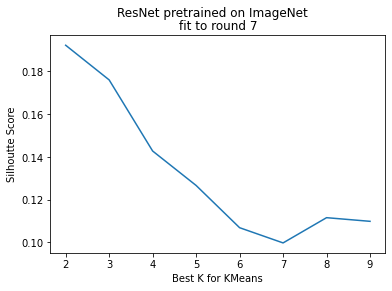

In [ ]:
#sil_name = '50res_fit7_hatsil.png'
plt.plot(k_vals, sil_score)
plt.ylabel('Silhoutte Score')
plt.xlabel('Best K')
plt.title('PCA dim from 2048 to 114')
#plt.title('fit to round 7')
plt.suptitle('ResNet pretrained on ImageNet')
#plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/model_charts/{}'.format(sil_name))
plt.show()

Plot the Elbow Curve

In [ ]:
#elb_name = '50res_7_hatelb.png'

# plot the cost against K values
plt.figure(figsize = (8,6))
plt.plot(range(1, k_max + 2), cost, color ='g', linewidth ='3')
plt.title('PCA dim from 2048 to 114')
#plt.title('fit to round 7')
plt.suptitle('Elbow Curve of Pretrained ResNet (ImageNet)')
plt.xlabel("K value")
plt.ylabel("Squared Error")

#plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/model_charts/{}'.format(elb_name))

plt.show() 

# Apply optimal K with clustering for labeling

In [39]:
X = []
y_train = []
# get image and label data
for x, lb in tqdm(test_loader):
  X.append(x)
  y_train.append(lb)


100%|██████████| 254/254 [01:36<00:00,  2.63it/s]


In [40]:
y_train_ = np.array(y_train)
x_train_ = np.array([t.numpy() for t in X])

print("shape of y: ", (y_train_).shape)
print("Type of y: ", type(y_train_))
print("shape of X: ", x_train_.shape)
print("Type of X: ", type(x_train_))

X_train = x_train_.reshape(x_train_.shape[0], -1) # reshaped to # samples and flattened dims
print("Shape of flattened X: ", X_train.shape)

shape of y:  (254,)
Type of y:  <class 'numpy.ndarray'>
shape of X:  (254, 1, 3, 368, 284)
Type of X:  <class 'numpy.ndarray'>
Shape of flattened X:  (254, 313536)


In [41]:
# get reduced 
w_pca = run_pca(X_train)

Number of components before PCA:  313536
Number of components after PCA 0.98: 236
Dim after PCA:  (254, 236)


In [42]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(w_pca)
kmeans.labels_

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 2, 0, 2, 1, 1, 2, 0, 1, 0, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0,
       1, 0, 1, 2, 2, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1,
       0, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 2, 2, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 2, 0,
       1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2, 1,
       1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1,
       1, 1, 0, 0, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 0, 0, 1, 2, 2, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1], dtype=int32)

In [43]:
clusters = kmeans.fit_predict(w_pca)
print("cluster center shape: ", kmeans.cluster_centers_.shape)
print("label shape: ", kmeans.labels_.shape)

cluster center shape:  (3, 236)
label shape:  (254,)


In [48]:
raw_data = False
if raw_data == True:
  if m == 'res50':
    fig, ax = plt.subplots(1, 3, figsize=(9, 11))
    centers = kmeans.cluster_centers_.reshape(3, 368, 284, 3)
    for axi, center in zip(ax.flat, centers):
        axi.set(xticks=[], yticks=[])
        axi.imshow(center*255, interpolation='nearest', cmap=plt.cm.binary)
  else:
    fig, ax = plt.subplots(1, 3, figsize=(9, 11))
    centers = kmeans.cluster_centers_.reshape(3, 368, 284)
    for axi, center in zip(ax.flat, centers):
        axi.set(xticks=[], yticks=[])
        axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Calculate Accuracy

In [45]:
labels = np.zeros_like(kmeans.labels_)
for i in range(3):
    mask = (kmeans.labels_ == i)
    #print(mask)
    labels[mask] = mode(y_train_[mask])[0]


accuracy_score(y_train_, labels)


0.7913385826771654

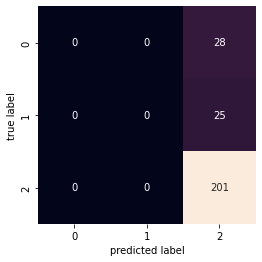

In [46]:
matrix = confusion_matrix(y_train_, labels)
sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1,2],
            yticklabels=[0,1,2])
plt.ylabel('true label')
plt.xlabel('predicted label');

Using NHATS label for round 7 test set data, fit on Pretrained ReNet50 on ImageNet only using 3 clusters was 79% accurate compared to cluster labels. This set is unbalanced and is over-predicting the most common class. 


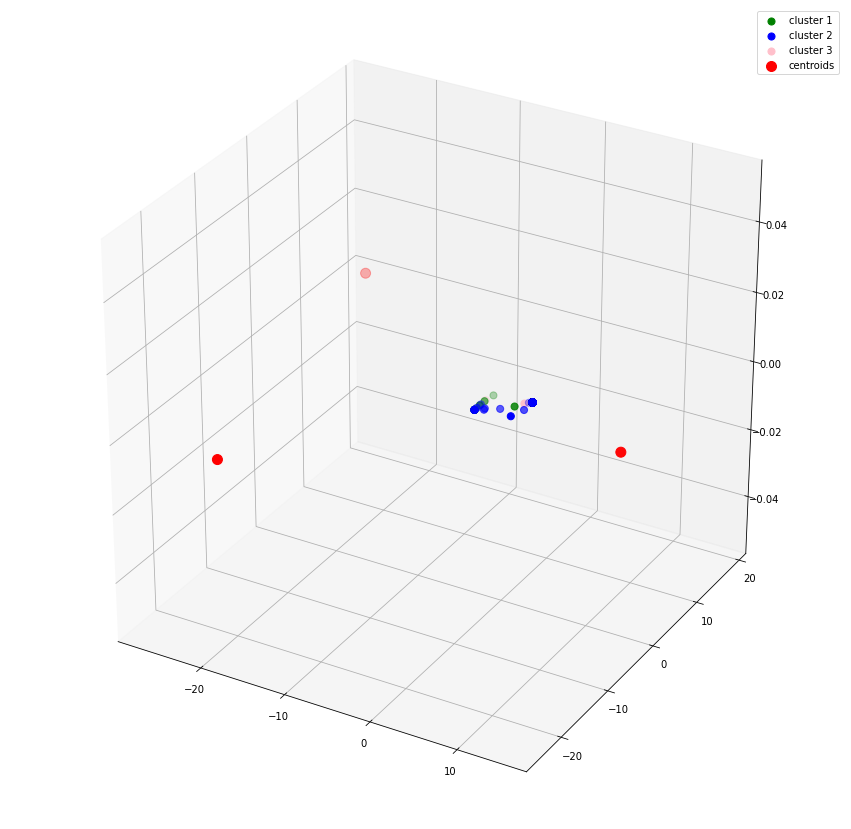

In [47]:
#y_pred = kmeans.predict(X_train)
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(X_train[clusters == 0,0],X_train[clusters == 0,1],s = 50, c = 'green', label = "cluster 1")
plt.scatter(X_train[clusters == 1,0],X_train[clusters == 1,1],s = 50, c = 'blue', label = "cluster 2")
plt.scatter(X_train[clusters == 2,0],X_train[clusters == 2,1],s = 50, c = 'pink', label = "cluster 3")
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s = 100, c = "red", label = "centroids")
plt.legend()
plt.show()